# GC Logs Clustering

In [4]:
! pip install yellowbrick xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 6.2 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
%cd ..
import os
import glob 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from yellowbrick.cluster import KElbowVisualizer
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from util.dataset_util import get_data_from_csv

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

scaler = MinMaxScaler()

#This is needed so we can display plotly plots properly
init_notebook_mode(connected=True)

/Users/ellkrauze/projects/gc-ml


/var/folders/dn/p1_3j9fs78g4wn8r0hcrqks40000gn/T/ipykernel_55591/1348600749.py:23: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [77]:
def get_data(path, goals):
    """Read summaries from a folder,
    create Dataframe from it with metrics set.

    Args:
        path (str): Path to the summaries to read.
        goals (list[str]): Summaries fields that define target variable.
    
    Returns:
        (pd.DataFrame) Summary dataframe
    """
    assert os.path.exists(path), f"Path {path} does not exist!"
    assert len(goals) != 0, "Metric fields cannot be empty!"
    
    dfs = []
    for df_path in glob.glob(os.path.join(path,"*.csv")):
        xmx = int(df_path.split('_')[-3])
        x, y, z =  get_data_from_csv(df_path, goals)
        
        # print(z)
        # assert len(z) == len(goals), f"Got {len(z)} values, {len(goals)} expected"
        # print(f"Got {len(z)} ")
        df = pd.DataFrame({
            # "MaxTenuringThreshold": y,
            # "ParallelGCThreads": x,
            # "Xmx": xmx,
        })
        df[goals] = z
        dfs.append(df)
    result_df = pd.concat(dfs)
    
    return result_df.copy()

## 1. Read Data

In [78]:
sample_path = os.path.join("summaries_avrora/summary_gc_avrora_2_4_1.csv")

# Get columns that are not boolean.
sample_df = pd.read_csv(sample_path, sep=';')
sample_df = sample_df[(sample_df.iloc[:, 2] != " bool")]
summary_fields = sample_df.T.iloc[0, 1:].values
summary_fields

array(['totalHeapUsedMax', 'totalHeapUsedMaxpc', 'totalTenuredAllocMax',
       'totalTenuredUsedMax', 'totalTenuredUsedMaxpc',
       'totalYoungAllocMax', 'totalYoungUsedMax', 'totalYoungUsedMaxpc',
       'totalPermAllocMax', 'totalPermUsedMax', 'totalPermUsedMaxpc',
       'avgfootprintAfterFullGC', 'avgfootprintAfterFullGCσ',
       'freedMemoryByFullGC', 'freedMemoryByFullGCpc',
       'avgFreedMemoryByFullGC', 'avgFreedMemoryByFullGCσ',
       'slopeAfterFullGC', 'avgRelativePostFullGCInc',
       'avgfootprintAfterGC', 'avgfootprintAfterGCσ', 'slopeAfterGC',
       'avgRelativePostGCInc', 'freedMemoryByGC', 'freedMemoryByGCpc',
       'avgFreedMemoryByGC', 'avgFreedMemoryByGCσ', 'avgPromotion',
       'promotionTotal', 'pauseCount', 'avgPause', 'avgPauseσ',
       'minPause', 'maxPause', 'gcPauseCount', 'avgGCPause',
       'avgGCPauseσ', 'fullGcPauseCount', 'avgFullGCPause',
       'avgFullGCPauseσ', 'minFullGCPause', 'maxFullGCPause',
       'accumPause', 'fullGCPause', 'full

In [79]:
len(summary_fields)

54

In [80]:
df = pd.concat(
    [
        get_data("summaries_avrora", summary_fields),
        get_data("summaries_kafka", summary_fields)
    ]
)

print("Size: ", df.size)
print("Shape: ", df.shape)
print("Rows: ", len(df))
df.head(5)

Size:  19440
Shape:  (360, 54)
Rows:  360


,totalHeapUsedMax,totalHeapUsedMaxpc,totalTenuredAllocMax,totalTenuredUsedMax,totalTenuredUsedMaxpc,totalYoungAllocMax,totalYoungUsedMax,totalYoungUsedMaxpc,totalPermAllocMax,totalPermUsedMax,...,fullGCPausePc,gcPause,gcPausePc,footprint,freedMemory,throughput,totalTime,freedMemoryPerMin,gcPerformance,fullGCPerformance
0,131.0,8.7,1008.0,3355.0,0.3,500.5,129.220993,25.799999,0.0,0.0,...,89.900002,0.04,10.1,1508.0,560.0,99.699997,124.0,269.230988,14920.583984,6134.620117
0,161.0,10.7,1008.0,3355.0,0.3,500.5,159.041000,31.799999,0.0,0.0,...,91.400002,0.04,8.6,1508.0,582.0,99.639999,125.0,278.984985,14959.634766,4953.667969
0,161.0,10.7,1008.0,3409.0,0.3,500.5,159.039993,31.799999,0.0,0.0,...,91.699997,0.04,8.3,1508.0,587.0,99.709999,151.0,232.098007,16238.272461,5117.300781
0,161.0,10.7,1008.0,3355.0,0.3,500.5,159.041000,31.799999,0.0,0.0,...,90.800003,0.04,9.2,1508.0,579.0,99.699997,155.0,223.451004,13366.382812,4824.204102
0,154.0,10.2,1008.0,3354.0,0.3,500.5,151.585999,30.299999,0.0,0.0,...,91.699997,0.04,8.3,1508.0,573.0,99.669998,152.0,225.132004,13693.045898,4424.913086


In [81]:
target = "fullGCPause"
X = df
# X = df[df.columns[~df.columns.isin([target])]]
Y = df[target]

print("X - columns:", X.shape)
print("Y - target columns:", Y.shape)

X - columns: (360, 54)
Y - target columns: (360,)


### 1.1. EDA

<Axes: >

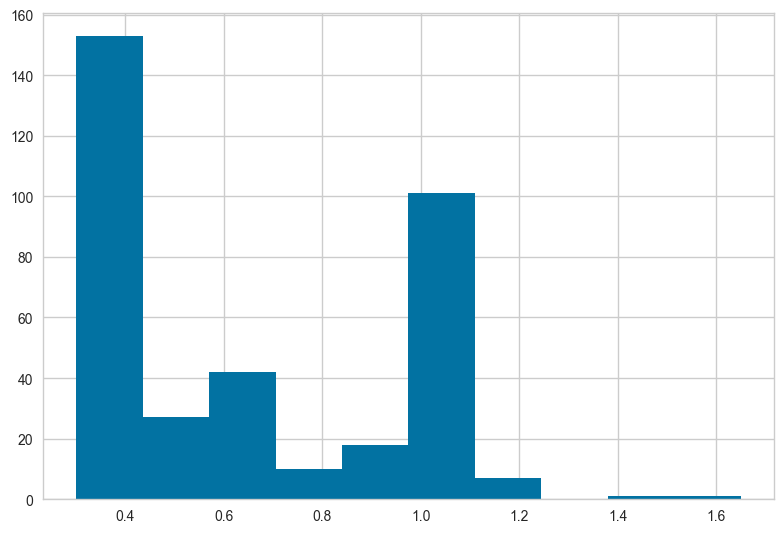

In [82]:
df[target].hist()

## 2. Preprocess data

Now, before we get into clustering our data, we just need to do one more thing: feature-scale our numerical variables.

We need to do this because, while each of our categorical variables hold values of either 0 or 1, some of our numerical variables hold values like 2596 and 2785. If we were to leave our data like this, then K-Means Clustering would not give us such a nice result, since K-Means Clustering measures the euclidean distance between data-points. This means that, if we were to leave our numeical variables un-scaled, then most of the distance measured between points would be attributed to the larger numerical variables, rather than any of the categorical variables.

To fix this problem we will scale all of our numerical variables through the use of sklearn's StandardScaler tool. This tool allows us to scale each numerical variable such that each numerical variable's mean becomes 0, and it's variance becomes 1. This is a good way to make sure that all of the numerical variables are on roughly the same scale that the categorical (binary) variables are on.

In [83]:
cols = X.columns
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=[cols])
X = X.dropna(axis=1)  # drop columns with missing values 

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning:

All-NaN slice encountered

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:481: RuntimeWarning:

All-NaN slice encountered



In [100]:
X.head()

,totalHeapUsedMax,totalHeapUsedMaxpc,totalTenuredAllocMax,totalTenuredUsedMax,totalTenuredUsedMaxpc,totalYoungAllocMax,totalYoungUsedMax,totalYoungUsedMaxpc,totalPermAllocMax,totalPermUsedMax,...,fullGCPausePc,gcPause,gcPausePc,footprint,freedMemory,throughput,totalTime,freedMemoryPerMin,gcPerformance,fullGCPerformance
0,0.000000,0.000000,0.0,0.688107,0.0,0.0,0.000000,0.00000,0.0,0.0,...,0.352518,0.214286,0.647482,0.0,0.003474,0.978819,0.054388,0.004605,0.022846,0.601201
1,0.010084,0.033113,0.0,0.688107,0.0,0.0,0.010608,0.07772,0.0,0.0,...,0.460432,0.214286,0.539568,0.0,0.006530,0.974281,0.054845,0.004784,0.022955,0.485268
2,0.010084,0.033113,0.0,0.699730,0.0,0.0,0.010608,0.07772,0.0,0.0,...,0.482014,0.214286,0.517986,0.0,0.007225,0.979576,0.066728,0.003921,0.026522,0.501332
3,0.010084,0.033113,0.0,0.688107,0.0,0.0,0.010608,0.07772,0.0,0.0,...,0.417266,0.214286,0.582734,0.0,0.006114,0.978819,0.068556,0.003762,0.018511,0.472559
4,0.007731,0.024834,0.0,0.687892,0.0,0.0,0.007956,0.05829,0.0,0.0,...,0.482014,0.214286,0.517986,0.0,0.005280,0.976550,0.067185,0.003793,0.019422,0.433361


## 3. K-Means Clustering

### 3.1. KElbowVisualizer

Elbow Method to determine the number of clusters to be formed:

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/ellkrauze/projects/gc-ml/gc-ml-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Use

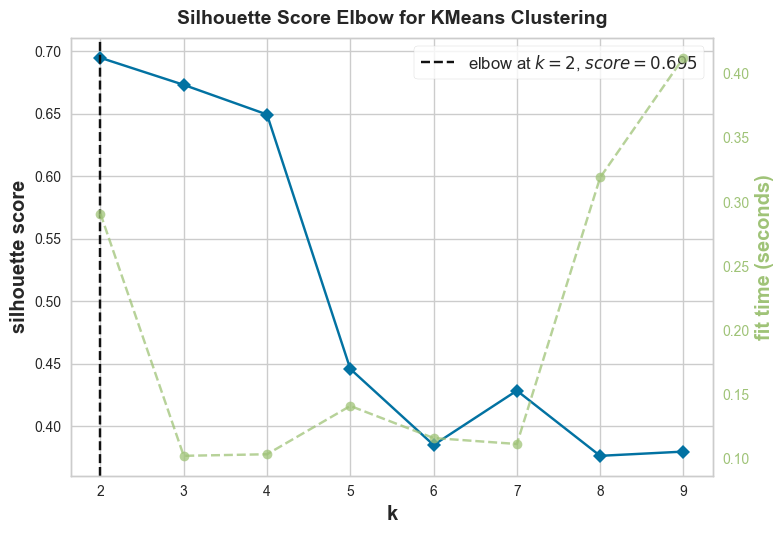

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [101]:
Elbow_M = KElbowVisualizer(
    KMeans(), 
    k = (2, 10), 
    locate_elbow=True, 
    metric = 'silhouette'
)
Elbow_M.fit(X)
Elbow_M.show()

### 3.2. K-means clusters

In [131]:
# num_clusters = Elbow_M.elbow_value_

num_clusters = 3
# num_clusters = 4


km = KMeans(
    n_clusters=num_clusters, 
    init='random',
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=0
)

km_predict = km.fit_predict(X)

In [132]:
new_X = X.copy()
new_X["cluster"] = km_predict
df["cluster"] = km_predict

In [133]:
df.head(20)

,totalHeapUsedMax,totalHeapUsedMaxpc,totalTenuredAllocMax,totalTenuredUsedMax,totalTenuredUsedMaxpc,totalYoungAllocMax,totalYoungUsedMax,totalYoungUsedMaxpc,totalPermAllocMax,totalPermUsedMax,...,gcPause,gcPausePc,footprint,freedMemory,throughput,totalTime,freedMemoryPerMin,gcPerformance,fullGCPerformance,cluster
0,131.0,8.7,1008.0,3355.0,0.3,500.5,129.220993,25.799999,0.0,0.0,...,0.04,10.1,1508.0,560.0,99.699997,124.0,269.230988,14920.583984,6134.620117,0
0,161.0,10.7,1008.0,3355.0,0.3,500.5,159.041000,31.799999,0.0,0.0,...,0.04,8.6,1508.0,582.0,99.639999,125.0,278.984985,14959.634766,4953.667969,0
0,161.0,10.7,1008.0,3409.0,0.3,500.5,159.039993,31.799999,0.0,0.0,...,0.04,8.3,1508.0,587.0,99.709999,151.0,232.098007,16238.272461,5117.300781,0
0,161.0,10.7,1008.0,3355.0,0.3,500.5,159.041000,31.799999,0.0,0.0,...,0.04,9.2,1508.0,579.0,99.699997,155.0,223.451004,13366.382812,4824.204102,0
0,154.0,10.2,1008.0,3354.0,0.3,500.5,151.585999,30.299999,0.0,0.0,...,0.04,8.3,1508.0,573.0,99.669998,152.0,225.132004,13693.045898,4424.913086,0
0,154.0,10.2,1008.0,3411.0,0.3,500.5,151.585999,30.299999,0.0,0.0,...,0.05,9.9,1508.0,580.0,99.690002,149.0,232.186996,12382.707031,4840.542969,0
0,154.0,10.2,1008.0,3408.0,0.3,500.5,151.585999,30.299999,0.0,0.0,...,0.05,10.0,1508.0,573.0,99.680000,145.0,235.531998,12098.226562,4819.890137,0
0,184.0,12.2,1008.0,4747.0,0.5,500.5,181.406006,36.200001,0.0,0.0,...,0.05,10.4,1508.0,693.0,99.699997,152.0,272.174988,14609.667969,7560.319824,0
0,154.0,10.2,1008.0,3411.0,0.3,500.5,151.585999,30.299999,0.0,0.0,...,0.05,10.4,1508.0,573.0,99.720001,156.0,220.128998,12418.443359,5154.275879,0
0,154.0,10.2,1008.0,3355.0,0.3,500.5,151.585999,30.299999,0.0,0.0,...,0.03,8.3,1508.0,576.0,99.650002,115.0,300.088989,17210.361328,5593.961914,0


### PCA Visualization

In [134]:
# X, y = df.drop("cluster", axis=1), df["cluster"]
# X = X.dropna(axis=1)

pca = PCA(n_components=2, random_state=42)
reducted_df = pd.DataFrame(pca.fit_transform(X))
reducted_df.columns = ["PC1", "PC2"]
reducted_df["cluster"] = km_predict
reducted_df

,PC1,PC2,cluster
0,-1.911377,-0.070360,0
1,-1.816665,-0.120714,0
2,-1.797809,-0.140107,0
3,-1.796917,-0.141948,0
4,-1.785753,-0.185713,0
...,...,...,...
355,1.580614,0.855539,1
356,2.104183,-0.650252,2
357,1.264011,1.754328,1
358,2.318171,-1.082292,2


In [135]:
import plotly.express as px

fig = px.scatter(reducted_df,
        x="PC1",
        y="PC2",
        color = "cluster",
)

fig.show()

In [136]:
fig = px.scatter(
        x = new_X["avgGCPause"].values.squeeze(),
        y = new_X["freedMemoryByGC"].values.squeeze(),
        color = new_X["cluster"].values.squeeze(),
).update_layout(
    xaxis_title="avgGCPause", yaxis_title="freedMemoryByGC",
)

fig.show()

In [ ]:
# fig = px.scatter_3d(
#     df,
#     x = "ParallelGCThreads",
#     y = "MaxTenuringThreshold",
#     z = "fullGCPause",
#     color = "cluster",
# )

# fig.show()

In [51]:
# df.to_csv("clustered_data.csv", index=False)

### Feature & Permutation Importance

In [137]:
new_target = "cluster"

# X_train, X_test, y_train, y_test = train_test_split(
#     new_X.drop(new_target, axis=1), new_X[new_target], test_size=0.2, random_state=42)


# Decision trees do not require the data to be normalized.
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(new_target, axis=1), df[new_target], test_size=0.2, random_state=42)

# Or without spliiting:
# X_train, y_train = df.drop(new_target, axis=1), df[new_target]

In [138]:
from sklearn import tree

feature_names = [each[0] for each in X.columns.values.squeeze()]
class_names = [str(each) for each in np.unique(y_train)]

clf = tree.DecisionTreeClassifier(random_state=42)
model = clf.fit(X_train, y_train)
# model = clf.fit(new_X.drop(new_target, axis=1), new_X[new_target])
# model = clf.fit(df.drop(new_target, axis=1), df[new_target])

In [139]:
y_train.value_counts()

cluster
0    143
2     82
1     63
Name: count, dtype: int64

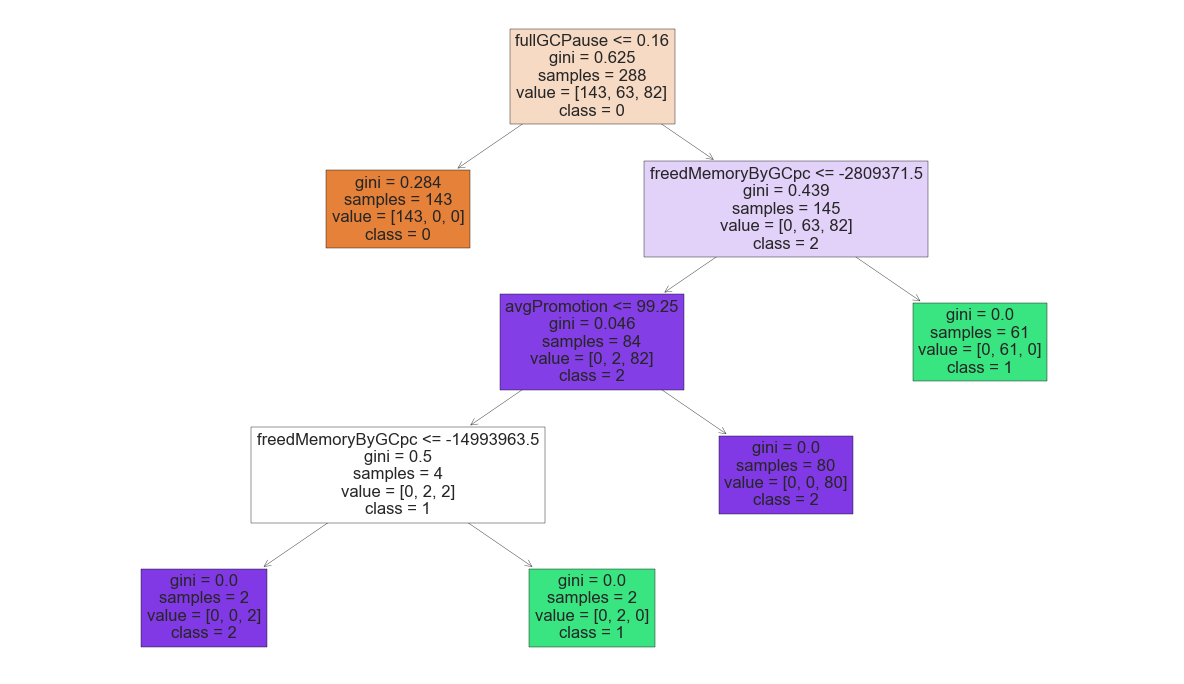

In [140]:
plt.figure(figsize=(12,7))  # set plot size (denoted in inches)

tree.plot_tree(
    model,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=12,
)

plt.show()

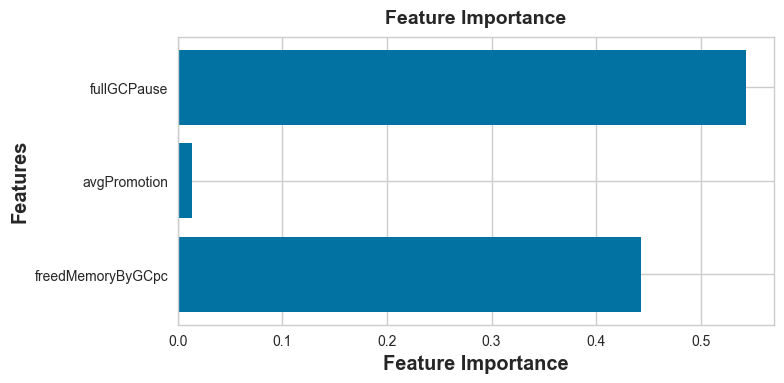

In [141]:
# Calculate feature importance
feature_importance = model.feature_importances_


# Plot feature importance
plt.figure(figsize=(8, 4))
plt.barh(
    np.array(feature_names)[np.nonzero(feature_importance)], 
    feature_importance[np.nonzero(feature_importance)]
)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

### Permutation Importance

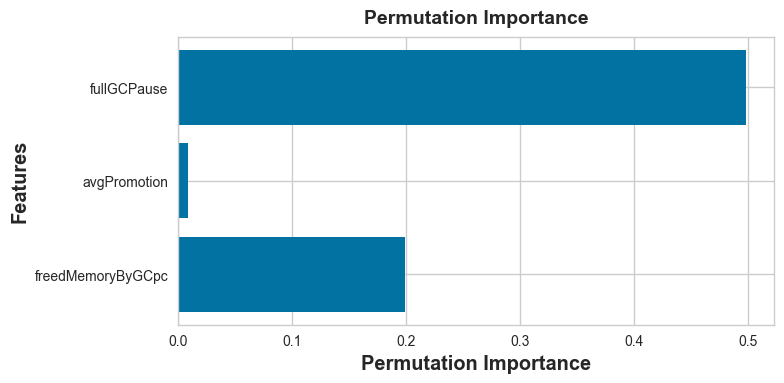

In [142]:
# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Plot permutation importance
plt.figure(figsize=(8, 4))

# sorted_idx = perm_importance.importances_mean.argsort()
sorted_idx = np.nonzero(perm_importance["importances_mean"])

plt.barh(
    np.array(feature_names)[sorted_idx],
    perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importance')

plt.show()
